In [1]:
import os
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error,mean_absolute_error
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#ADD ROLLOUT

FEATURES = ['rollout','is_off_day','hour','spv','day_of_week','temp']
LEVEL = 'portfolio'

COUNTRY = "Spain"
START_TRAIN = "2024-04-01"
START_TEST = "2024-06-02"

if COUNTRY == "Italy":
    suffix = "IT"
if COUNTRY == "Spain":
    suffix = 'ES'


In [2]:
def load_rollout(suffix):
    # Load the rollout data
    rollout = pd.read_csv(f'../data/rollout_data_{suffix}.csv')
    rollout['DATETIME'] = pd.to_datetime(rollout['DATETIME'])
    return rollout

def load_custom_rollout(suffix):
    #Load the special rollout data with low correlation filtered out
    rollout = pd.read_csv(f'../data/highcorr_rollout_{suffix}.csv')
    rollout['DATETIME'] = pd.to_datetime(rollout['DATETIME'])
    return rollout


def preprocess_rollout(data:pd.DataFrame,suffix:str, customer_id:int=None):
    # Preprocess the rollout data
    # Portfolio level - take the median of all customers
    # Customer level - take the customer_id column and fillna with 0

    if LEVEL == 'portfolio':
        data['rollout'] = data.drop(columns='DATETIME').median(axis=1)
    else:
        data['rollout'] = data[f'VALUEMWHMETERINGDATA_customer{suffix}_' + str(customer_id)].copy()

    data['rollout'] = data['rollout'].fillna(0)
    return data


In [3]:
def load_input_data(suffix:str):

    #Load environmental data
    env_data = pd.read_excel('../data/spv_ec00_forecasts_es_it.xlsx', sheet_name=suffix, index_col=0).reset_index(names='DATETIME')
    env_data['DATETIME'] = pd.to_datetime(env_data['DATETIME'])
    env_data['date'] = env_data['DATETIME'].dt.date

    #Load holiday data
    holidays = pd.read_excel(f"../data/holiday_{suffix}.xlsx")
    holidays['date'] = pd.to_datetime(holidays[f'holiday_{suffix}']).dt.date

    merged_df = pd.merge(env_data, holidays[['date', f'holiday_{suffix}']], how='left', on='date')

    merged_df['hour'] = merged_df['DATETIME'].dt.hour
    merged_df['month'] = merged_df['DATETIME'].dt.month
    merged_df['day_of_week'] = merged_df['DATETIME'].dt.dayofweek

    ##BINARY 1=HOLIDAY OR WEEKEND
    merged_df['is_off_day'] = 0
    merged_df.loc[~merged_df[f'holiday_{suffix}'].isna(), 'is_off_day'] = 1
    merged_df.loc[merged_df['day_of_week'].isin([5, 6]), 'is_off_day'] = 1

    return merged_df


In [4]:
def load_target_data(suffix:str):
    data = pd.read_csv(f"../data/historical_metering_data_{suffix}.csv")
    data['DATETIME'] = pd.to_datetime(data['DATETIME'])
    return data

def preprocess_target_data(data: pd.DataFrame,suffix:str, customer_id:int=None):
    # For portfolio level, sum the data across all customers
    # For customer level, filter by customer_id
    if LEVEL == 'portfolio':
        data['target'] = data.drop(columns=['DATETIME']).sum(axis=1)
    else:
        data['target'] = data[f'VALUEMWHMETERINGDATA_customer{suffix}_' + str(customer_id)].copy()
    return data[['DATETIME', 'target']]


In [13]:
y_train.shape

(1488,)

In [12]:
load_input_data(suffix)

,DATETIME,spv,temp,date,holiday_ES,hour,month,day_of_week,is_off_day
0,2022-01-01 00:00:00,0.000000,9.2,2022-01-01,2022-01-01,0,1,5,1
1,2022-01-01 01:00:00,0.000000,8.9,2022-01-01,2022-01-01,1,1,5,1
2,2022-01-01 02:00:00,0.000000,8.8,2022-01-01,2022-01-01,2,1,5,1
3,2022-01-01 03:00:00,0.000000,8.6,2022-01-01,2022-01-01,3,1,5,1
4,2022-01-01 04:00:00,0.000000,8.1,2022-01-01,2022-01-01,4,1,5,1
...,...,...,...,...,...,...,...,...,...
28456,2025-03-31 19:00:00,8910.698834,17.2,2025-03-31,NaT,19,3,0,0
28457,2025-03-31 20:00:00,922.164988,15.1,2025-03-31,NaT,20,3,0,0
28458,2025-03-31 21:00:00,0.000000,13.5,2025-03-31,NaT,21,3,0,0
28459,2025-03-31 22:00:00,0.000000,12.6,2025-03-31,NaT,22,3,0,0


In [5]:
#prepare data

#LOAD DATA 
input_data = load_input_data(suffix)
rollout_data = load_rollout(suffix) ##CAN USE load_custom_rollout(suffix) FOR HIGH ONLY ROLLOUT WITH HIGH CORR
target_data = load_target_data(suffix) 

#START LOOP HERE BY CUSTOMER ID, IF NOT PORTFOLIO LEVEL
processed_rollout_data = preprocess_rollout(rollout_data, suffix, customer_id=None)
input_data = pd.merge(input_data, processed_rollout_data[['DATETIME', 'rollout']], how='left', on='DATETIME')
processed_target_data = preprocess_target_data(target_data, suffix, customer_id=None)

merged_df = pd.merge(processed_target_data,input_data, how='left', on='DATETIME')

train_df = merged_df[(merged_df['DATETIME'] < START_TEST) & (merged_df['DATETIME'] >= START_TRAIN)]
test_df = merged_df[merged_df['DATETIME'] >= START_TEST]

X_train = train_df[FEATURES]
y_train = train_df['target']
X_test = test_df[FEATURES]
y_test = test_df['target']

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train, y_train = shuffle(X_train, y_train, random_state=42)

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)



GradientBoostingRegressor(random_state=42)

In [6]:
#FEATURE IMPORTANCE AND MODEL EVALUATION

feature_importances = model.feature_importances_

# Create a DataFrame to view the feature importances
importance_df = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df)

y_pred = model.predict(X_test)

mse = mean_absolute_error(y_test, y_pred)
mae = mean_squared_error(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)

Feature Importances:
       Feature  Importance
1   is_off_day    0.797004
4  day_of_week    0.064275
2         hour    0.052842
3          spv    0.039421
5         temp    0.033023
0      rollout    0.013436
Mean Absolute Error: 18.873678889366364
Mean Squared Error: 3.2717319995591363


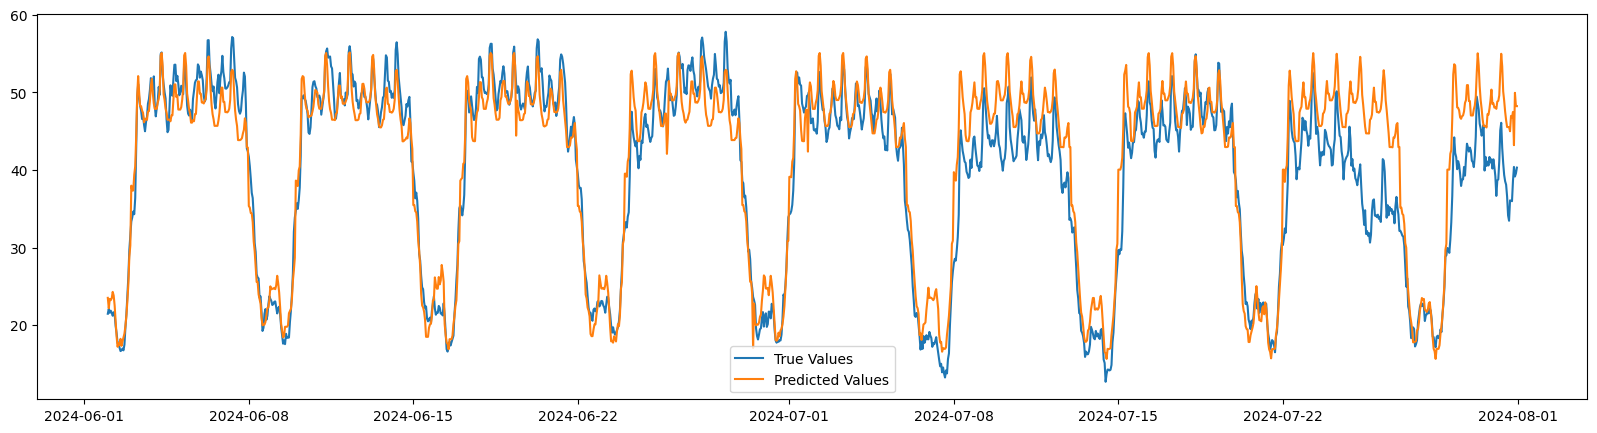

In [7]:
plt.figure(figsize=(20,5))
plt.plot(test_df['DATETIME'],y_test.reset_index(drop=True), label='True Values')
plt.plot(test_df['DATETIME'],y_pred, label='Predicted Values')
plt.legend()